In [1]:
print('import libraries')

import numpy as np
import scipy.integrate as it

import area as area

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import libraries


In [14]:
print('geometry of girder')
# soortelijke massa beton
gam_c = 24 #kN/m³

#parameters cross section
cs1 = area.Cross_section('cs1', [[0,0], [400,0], [400,130], [270,260],[270,740],[400,870],[400,1000],[0,1000],[0,870],[130,740],[130,260],[0,130]])
cs2 = area.Cross_section('cs2', [[0,0],[400,0],[400,1000],[0,1000]]) #T = [800,800],[800,1000],[-400,1000],[-400,800]

#parameters girder
L_uit = 2.2
L = 19.46/2-L_uit
A = cs1.area*1e-6 #cross section area
h = cs1.height/1000 #m

interval = L/100
L_x = np.arange(0,L+interval,interval)

# prestressed reinforcement
A_strands = 52.8 #mm²

reinf_strait = [[8*A_strands,h-0.04],[6*A_strands,h-0.08],[2*A_strands,h-0.115]] #vsp in rechte lijn [Ap,d]
reinf_bend = [[4*A_strands,h-0.425,h-0.02],[4*A_strands,h-0.525,h-0.06],[4*A_strands,h-0.895,h-0.1]] #vsp in boogstraal [Ap,d_edge,d_mid] d op liggereinde
f = [i[2]-i[1] for i in reinf_bend]
pos_knik = L-2.5

ep_strait = [i[1]-h/2 for i in reinf_strait]
ep_bend = [i[1]-h/2 for i in reinf_bend]


geometry of girder


In [65]:
# prestressing:
sigp_0 = 1235#MPa
sigp_inf = 0.8*sigp_0 #MPa

# Pointload:
F = 750 # [kN]

loc_F = 1.8 # unit= met
print('n = %s' %int(loc_F/interval))

n = 23


In [66]:
print('compute bending moments and shear')
#loads
Pm_strait = np.asarray([i[0]*sigp_inf * -10**-3 for i in reinf_strait])
Pm_bend = np.asarray([i[0]*sigp_inf * -10**-3 for i in reinf_bend])

Pm = np.sum(Pm_strait)+np.sum(Pm_bend)
qg = gam_c*A

#pointload from prestress
alpha_p = [i/pos_knik for i in f]
Fp = sum([i*a for i,a in zip(Pm_bend,alpha_p)])

# pointload
a_f = np.arange(0,L,interval)

# static Moments
Mpf = np.where(L_x<=pos_knik,Fp*(L-pos_knik)/L*L_x,(Fp*(L-pos_knik)/L*(pos_knik)-Fp*pos_knik/L*(L_x-pos_knik))) # bij doorgezaagde balk geldt: 0.5*Fp*L_x, 0.5*Fp*pos_knik
Mp = np.full_like(L_x,sum([P*e for P,e in zip(Pm_strait,ep_strait)])+sum([P*e for P,e in zip(Pm_bend,ep_bend)]))
Muit = -0.5* cs2.area*1e-6 * gam_c * L_uit**2
Mg = np.interp(L_x, [0, L], [Muit,0]) + 0.5 * qg * L_x * (L - L_x)

#shear (Nog uitzoeken)
Vpf = np.gradient(Mpf,L_x)
Vp = np.gradient(Mp,L_x)
Vg = np.gradient(Mg,L_x)

#moments and shear including pointload
M = np.empty([1, L_x.size])
V = np.empty_like(M)

for i in np.nditer(a_f):
    b_f = L-i
    mf = [np.where(L_x<=i,F*b_f/L*L_x,(F*b_f/L*(i)-F*i/L*(L_x-i)))]
    m = mf + Mpf + Mp + Mg
    vf = np.gradient(mf[0],L_x)
    v = vf + Vpf + Vp + Vg
    M = np.append(M,m, axis=0)
    V = np.append(V,[v], axis=0)

M = M[1:,:].T
V = V[1:,:].T

"""
        |+--> 'a', position of pointload
        |:
M/V=    |:
        |v Moment/shear at x

"""

compute bending moments and shear


"\n        |+--> 'a', position of pointload\n        |:\nM/V=    |:\n        |v Moment/shear at x\n\n"

Force due to prestressing is  -1460.6591999999998 kN


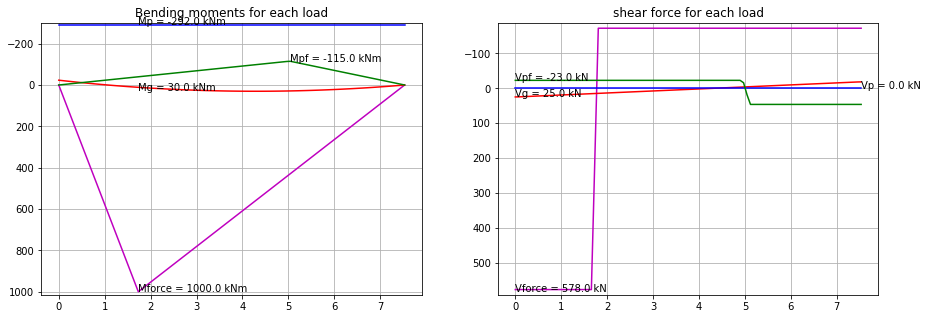

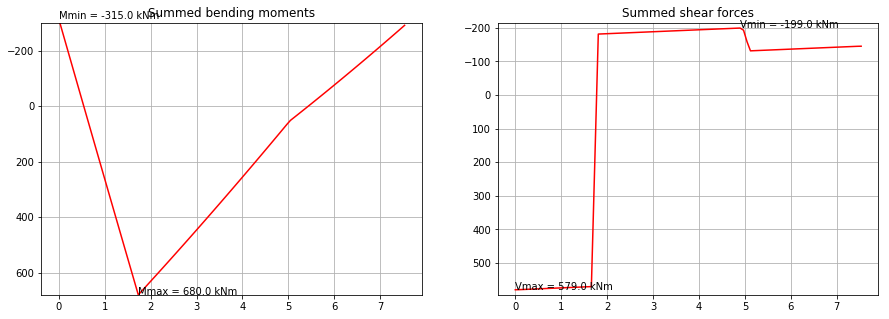

In [67]:
%matplotlib inline
#modelcheck with interval is 0.25 m, cross section is 400*1000 width*heigh
n = int(loc_F/interval)
print('Force due to prestressing is  %s kN' %Pm)

fig1 = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(L_x,(M[:,n]-Mg-Mpf-Mp),'m')
ax1.text(L_x[n],(M[n,n]-Mg[n]-Mpf[n]-Mp[n]),'Mforce = %s kNm' % np.round(M[n,n]-Mg[n]-Mpf[n]-Mp[n]))

ax1.plot(L_x,Mg, 'r')
ax1.text(L_x[n],Mg[np.argmax(Mg)],'Mg = %s kNm'%np.round(Mg[np.argmax(Mg)]))

ax1.plot(L_x,Mp, 'b')
ax1.text(L_x[n],Mp[np.argmax(Mp)],'Mp = %s kNm'%np.round(Mp[np.argmax(Mp)]))

ax1.plot(L_x,Mpf, 'g')
ax1.text(L_x[np.argmin(Mpf)],Mpf[np.argmin(Mpf)],'Mpf = %s kNm'%np.round(Mpf[np.argmin(Mpf)]))

ax1.set_title('Bending moments for each load')
ax1.set_ylim((M[n,n]-Mg[n]-Mpf[n]-Mp[n])+15,-300)
ax1.grid(True)

ax2 = plt.subplot(1,2,2)

ax2.plot(L_x,(V[:,n]-Vg-Vpf-Vp),'m')
ax2.text(L_x[0],(V[n-1,n]-Vg[n]-Vpf[n]-Vp[n]+5),'Vforce = %s kN' % np.round(V[n-1,n]-Vg[n]-Vpf[n]-Vp[n]))

ax2.plot(L_x,Vg, 'r')
ax2.text(L_x[0],Vg[np.argmax(Vg)],'Vg = %s kN'%np.round(Vg[np.argmax(Vg)]))

ax2.plot(L_x,Vp, 'b')
ax2.text(L_x[-1],Vp[np.argmax(Vp)],'Vp = %s kN'%np.round(Vp[np.argmax(Vp)]))

ax2.plot(L_x,Vpf, 'g')
ax2.text(L_x[0],Vpf[np.argmin(Vpf)],'Vpf = %s kN'%np.round(Vpf[np.argmin(Vpf)]))

ax2.set_title('shear force for each load')
ax2.set_ylim((V[:,n]-Vg-Vpf-Vp).max()+15,(V[:,n]-Vg-Vpf-Vp).min()-15)
ax2.grid(True)
plt.show()

fig2 = plt.figure(figsize=(15,5))
ax3 = plt.subplot(1,2,1)
ax3.plot(L_x,M[:,n], 'r')
ax3.text(L_x[np.argmin(M[:,n])],M[np.argmin(M[:,n]),n],'Mmin = %s kNm'%np.round(M[np.argmin(M[:,n]),n]))
ax3.text(L_x[np.argmax(M[:,n])],M[np.argmax(M[:,n]),n],'Mmax = %s kNm'%np.round(M[np.argmax(M[:,n]),n]))

ax3.set_title('Summed bending moments')
ax3.set_ylim(M[:,n].max(),-300)
ax3.grid(True)

ax4 = plt.subplot(1,2,2)
ax4.plot(L_x,V[:,n], 'r')
ax4.text(L_x[np.argmin(V[:,n])],V[np.argmin(V[:,n]),n],'Vmin = %s kNm'%np.round(V[np.argmin(V[:,n]),n]))
ax4.text(L_x[np.argmax(V[:,n])],V[np.argmax(V[:,n]),n],'Vmax = %s kNm'%np.round(V[np.argmax(V[:,n]),n]))

ax4.set_title('Summed shear forces')
ax4.set_ylim(V[:,n].max()+15,V[:,n].min()-15)
ax4.grid(True)
plt.show()

In [68]:
print("compute stresses")
sig_bend_unit = cs1.sig_bend_unit()[:,0]
sig_norm_unit = cs1.sig_norm_unit()[:,0]
tau_unit = cs1.tau_unit()[:,0]

sig_bend = sig_bend_unit[:,None,None] * M * 1e6
sig_norm = sig_norm_unit[:,None,None] * np.full_like(M,(np.sum(Pm_bend)+np.sum( Pm_strait))*1e3)
sig_tot = sig_bend + sig_norm

tau = tau_unit[:,None,None]* V * 1e3

prin_stress = area.principle_stress_section(sig_tot,tau) #out is sig1, sig2, theta


compute stresses


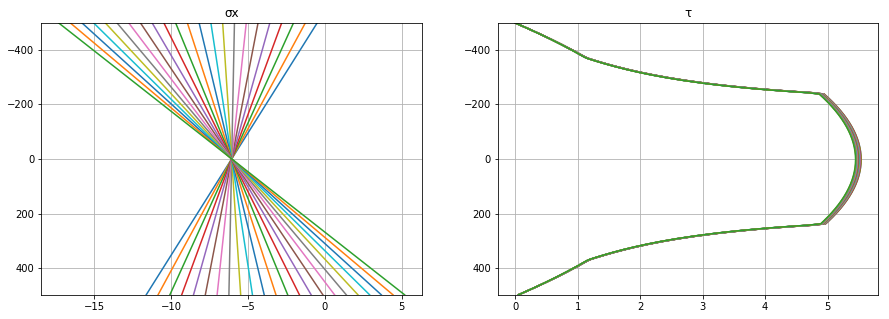

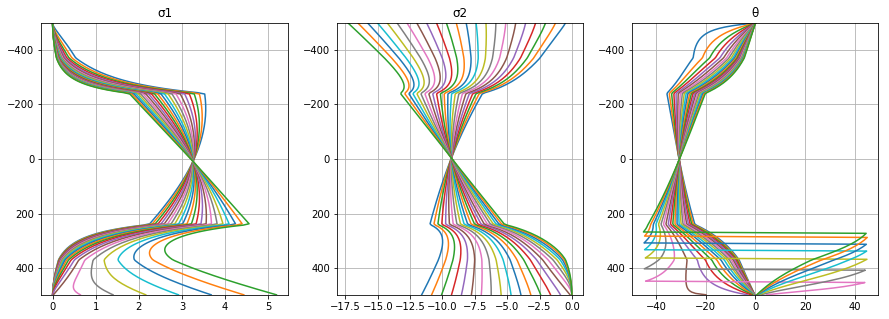

In [69]:
# %matplotlib inline
#NOTE!! tekenafspraken assenstelsel: x in overspanningsrichting, y diepterichting, z liggerhoogte gerekend vanuit neutrale lijn onderzijde positief
#(positief moment geeft trek (positieve spanning) aan onderzijde)
q= int(loc_F/interval)

fig1 = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(sig_tot[:,:q,q],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
ax1.set_ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
ax1.grid(True)
ax1.set_title(chr(963)+'x')

ax2 = plt.subplot(1,2,2)
ax2.plot(tau[:,:q,q],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
ax2.set_ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
ax2.grid(True)
ax2.set_title(chr(964))

fig2 = plt.figure(figsize=(15,5))
ax3 = plt.subplot(1,3,1)
ax3.plot(prin_stress[0][:,:q,q],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
ax3.set_ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
ax3.grid(True)
ax3.set_title(chr(963)+'1')

ax4 = plt.subplot(1,3,2)
ax4.plot(prin_stress[1][:,:q,q],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
ax4.set_ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
ax4.grid(True)
ax4.set_title(chr(963)+'2')

ax5 = plt.subplot(1,3,3)
ax5.plot(prin_stress[2][:,:q,q],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
ax5.set_ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
ax5.grid(True)
ax5.set_title(chr(952))

plt.show()


In [70]:
# %matplotlib qt 
# fig = plt.figure(figsize=(100,40))
# ax = fig.gca(projection='3d')

# loc_F = 2 # unit= meter
# X = L_x #location at beam
# Y = cs1.width_at_z()[::-1,1]-cs1.center_of_gravity #location on crossection

# X,Y = np.meshgrid(X,Y)

# Z = prin_stress[0][:,:,int(loc_F/interval)]

# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_zlim(Z.min(), Z.max())
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()

In [71]:
print(tau.shape)

(200, 101, 100)
